# Trading Strategy Reconstruction: <Strategy Name>


## Introduction
Briefly describe the trading strategy. Mention the academic paper it comes from, the authors, and the main premise of the strategy.


## Background

#### Theory
Provide a summary or key points from the academic paper. This might include:
- Assumptions made in the paper.
- The theoretical foundation of the strategy.
- Any supporting or opposing views from other academics or practitioners.

#### Key Concepts
Present and explain key formulas or concepts from the paper. This might include algorithm pseudocode, mathematical formulas, or other theoretical concepts vital to understanding the strategy.

## Data Acquisition and Cleaning

#### Data Sources
Discuss the data sources used, e.g., Yahoo Finance, proprietary databases, etc.

In [1]:
# Step 1: Install necessary packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


#### Data Retrieval
Include code cells that fetch the data. If you're using `yfinance`, show how you're fetching the data.

In [73]:
def download_data(tickers, start_date, end_date):
    try:
        # Download the historical data using the yfinance library
        df = yf.download(tickers, start=start_date, end=end_date, group_by='tickers', interval="2m")
        # Rename the 'Adj Close' column to 'Adj_Close'
        df.rename(columns={"Adj Close": "Adj_Close"}, inplace=True)
        return df
    except Exception as e:
        print(f"Error occurred while trying to download data: {e}")
        return None

futures_codes = ["MSFT", "SPY"]
start_date = "2023-06-18"
end_date = "2023-08-08"

historical_data = download_data(futures_codes, start_date, end_date)


[*********************100%***********************]  2 of 2 completed


#### Data Cleaning
Present any steps or transformations you undertake to clean or preprocess the data. This might include handling missing data, outliers, or converting data to a format suitable for backtesting.

In [74]:
def null_check_and_clean(df):
    if df.isnull().sum().sum() > 0:
        null_columns = df.columns[df.isnull().any()]
        print("Null value count by column:")
        print(df[null_columns].isnull().sum())
        print("\nRows with null values:")
        print(df[df.isnull().any(axis=1)][null_columns])
        df.dropna(inplace=True)
        print("\nNull values dropped.")
    else:
        print("\nNo null values in dataframe.")
    return df

def check_data_length(df):
    lengths = {ticker: len(data) for ticker, data in df.items()}
    length_set = set(lengths.values())
    if len(length_set) > 1:
        print("Data lengths are not equal!")
        for ticker, length in lengths.items():
            print(f"Length of data for {ticker}: {length}")
    else:
        print(f"All data series have the same length: {next(iter(length_set))}")

historical_data = null_check_and_clean(historical_data)
check_data_length(historical_data)

def create_df(df):
    # Create a new dataframe with only close prices
    close_prices = pd.DataFrame()
    
    # Check if the dataframe has a MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        for ticker in df.columns.levels[0]:
            close_prices[ticker] = df[ticker]['Close']
    else:
        # Ensure 'Close' column exists in the dataframe
        if 'Close' in df.columns:
            close_prices = df[['Close']]
        else:
            raise KeyError("The dataframe doesn't have a 'Close' column.")
    
    return close_prices

close_prices =create_df(historical_data)
filtered_df = close_prices[[time >= pd.Timestamp("9:30").time() and time < pd.Timestamp("10:00").time() for time in close_prices.index.time]]

Null value count by column:
MSFT  Open         1
      High         1
      Low          1
      Close        1
      Adj_Close    1
      Volume       1
dtype: int64

Rows with null values:
                    MSFT                                
                    Open High Low Close Adj_Close Volume
Datetime                                                
2023-08-04 13:06:00  NaN  NaN NaN   NaN       NaN    NaN

Null values dropped.
All data series have the same length: 4971


                           MSFT         SPY
Datetime                                   
2023-06-30 09:30:00  339.160004  441.380005
2023-06-30 09:32:00  339.240112  441.779999
2023-06-30 09:34:00  339.433289  441.617310
2023-06-30 09:36:00  339.190002  441.799988
2023-06-30 09:38:00  339.510010  441.890015
...                         ...         ...
2023-08-07 09:50:00  330.540009  448.809998
2023-08-07 09:52:00  330.640015  449.049988
2023-08-07 09:54:00  330.730011  448.920013
2023-08-07 09:56:00  330.700012  448.760010
2023-08-07 09:58:00  329.785004  448.489990

[390 rows x 2 columns]


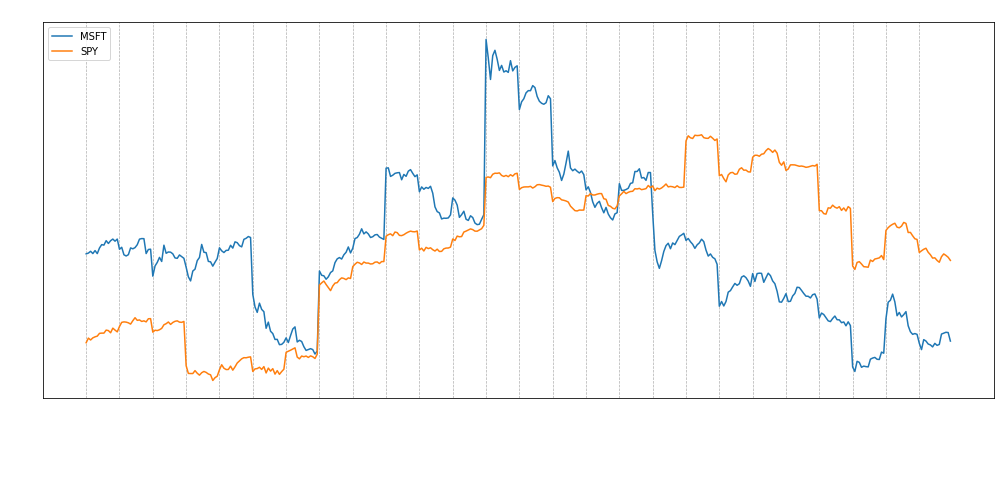

In [104]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_data(df, title, is_normalized=False):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot data against a simple range
    for column in df.columns:
        ax.plot(range(df.shape[0]), df[column].values, label=column)
        
    ax.legend(loc='upper left')
    
    # Set axis text color to white
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    
    ax.set_title(title)
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Normalized Price' if is_normalized else 'Price ($)')
    
    # Set x-ticks to represent specific dates and times
    start_ticks = df.index[df.index.time == pd.Timestamp("9:30").time()].strftime('%Y-%m-%d %H:%M').tolist()
    end_ticks = df.index[df.index.time == pd.Timestamp("10:30").time()].strftime('%Y-%m-%d %H:%M').tolist()
    date_ticks = start_ticks+end_ticks
    ax.set_xticks([df.index.get_loc(dt) for dt in date_ticks if dt in df.index])
    ax.set_xticklabels(date_ticks, rotation=45, ha='right')

    # Add a grid for the x-ticks
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
    
    plt.tight_layout()
    plt.show()



def normalize_zscore(df):
    # Calculate the mean and standard deviation per column
    mean = df.mean()
    std_dev = df.std()

    # Calculate the z-scores
    zscores = (df - mean) / std_dev

    return zscores
print(filtered_df)
normalized_data = normalize_zscore(filtered_df)
plot_data(normalized_data, 'Normalized Close Prices Over Time', is_normalized=True)

In [100]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

class Cointegration:
    def __init__(self, series1, series2):
        self.series1 = series1
        self.series2 = series2
        self.signif_value = 0.05
        
    def adf_test(self):
        """Perform ADF test on both series"""
        self._run_adf(self.series1, "Series 1")
        self._run_adf(self.series2, "Series 2")

    def _run_adf(self, series, series_name):
        """Helper function to run ADF test"""
        dftest = adfuller(series, autolag='AIC')
        adf = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags', '# Observations'])
        for key, value in dftest[4].items():
            adf['Critical Value (%s)' % key] = value
        print(f"Results for {series_name}:")
        print(adf)
        
        p = adf['p-value']
        if p <= self.signif_value:
            print(f"{series_name} is Stationary at {self.signif_value} level of significance\n")
        else:
            print(f"{series_name} is Non-Stationary at {self.signif_value} level of significance\n")

    def engle_granger_test(self):
        """Perform the Engle-Granger test for cointegration"""
        t_stat, p_value, _ = coint(self.series1, self.series2)
        print(f'Engle-Granger Test p-value: {p_value}')
        if p_value < self.signif_value:
            print(f"The series are cointegrated at {self.signif_value} level of significance.")
        else:
            print(f"The series are NOT cointegrated at {self.signif_value} level of significance.")

    def johansen_test(self):
        """Perform the Johansen test for cointegration"""
        dataframe = pd.concat([self.series1, self.series2], axis=1)
        
        # The det_order = -1 specifies no deterministic part in the model (i.e., constant or trend)
        result = coint_johansen(dataframe, det_order=-1, k_ar_diff=1)
        
        for trace, crit_val in zip(result.lr1, result.cvt[:, 1]):  # Using 5% critical values (index 1)
            if trace > crit_val:
                print(f"The series are cointegrated at {self.signif_value} level of significance.")
                return
        print(f"The series are NOT cointegrated at {self.signif_value} level of significance.")


In [103]:
coints= Cointegration(filtered_df['SPY'],filtered_df['MSFT'])
coints.adf_test()
coints.engle_granger_test()
coints.johansen_test()

Results for Series 1:
Test Statistic           -1.492250
p-value                   0.537341
# Lags                    0.000000
# Observations          389.000000
Critical Value (1%)      -3.447273
Critical Value (5%)      -2.868999
Critical Value (10%)     -2.570743
dtype: float64
Series 1 is Non-Stationary at 0.05 level of significance

Results for Series 2:
Test Statistic           -1.691581
p-value                   0.435455
# Lags                    0.000000
# Observations          389.000000
Critical Value (1%)      -3.447273
Critical Value (5%)      -2.868999
Critical Value (10%)     -2.570743
dtype: float64
Series 2 is Non-Stationary at 0.05 level of significance

Engle-Granger Test p-value: 0.7950609044862946
The series are NOT cointegrated at 0.05 level of significance.
The series are NOT cointegrated at 0.05 level of significance.


## Strategy Construction

#### Pseudocode
Provide a high-level pseudocode or step-by-step approach to the strategy's logic. This helps in understanding and then coding the strategy.

#### Strategy Implementation
The actual Python code that constructs the strategy. This might involve defining trading signals, calculating indicators, or any other computation that forms the strategy's logic.

## Backtesting

#### Setting Parameters
Define any parameters for backtesting - like initial capital, transaction costs, etc.

#### Running the Backtest
Show the code for running the backtest. This might involve looping through the data and applying the strategy logic to make buy/sell decisions.

#### Metrics & Results
Present key performance metrics: 
- Total Return
- Annualized Return
- Maximum Drawdown
- Sharpe Ratio, etc.

## Visualization

Provide visual representations:
- Cumulative returns over time.
- Drawdowns.
- Maybe a comparison with benchmark returns.
- Histogram of returns, etc.

## Conclusion

Summarize the findings:
- Did the strategy perform well?
- How did it compare to a benchmark or to expectations set out in the academic paper?
- Potential improvements or modifications.

## References

- List the academic papers, books, or any other resources referred to in the notebook.